In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [47]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

# prepare data

In [48]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
1509  0.288556  0.835296  0.722233  0.409043  0.914186  0.492303  0.950301   
1238  0.984813  0.956258  0.849559  0.226773  0.891901  0.435954  0.608810   
1736  0.817326  0.601110  0.370813  0.196454  0.513055  0.057367  0.285015   
1001  0.483636  0.882402  0.800979  0.189362  0.892233  0.373832  0.293675   
2141  0.125070  0.966016  0.828012  0.318085  0.930983  0.572018  0.719880   
...        ...       ...       ...       ...       ...       ...       ...   
2199  0.148321  0.964166  0.893830  0.306915  0.887078  0.621220  0.553087   
1206  0.926417  0.900908  0.847600  0.211525  0.879428  0.431556  0.385542   
680   0.462888  0.825202  0.642311  0.192553  0.795610  0.162067  0.294051   
1659  0.452406  0.746131  0.743389  0.208865  0.782970  0.132875  0.250753   
435   0.726203  0.784993  0.589226  0.232092  0.673374  0.110060  0.274096   

            F9        F5      F7     F12      F8  
1509  0.4580

In [49]:
dataset_arr=dataset.to_numpy()
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


# call the encoder

In [50]:
import pickle

# Load the encoder model from the saved file
with open("all_pkl_file/Encoder_3.pkl", "rb") as file: #"rb"= read mode
    encoder = pickle.load(file)

encoder


In [51]:
encoded_X = pd.DataFrame(encoder.predict(dataset))
encoded_X = encoded_X.add_prefix('feature_')

encoded_X_train = pd.DataFrame(encoder.predict(X_train))
encoded_X_train = encoded_X_train.add_prefix('feature_')

encoded_X_test = pd.DataFrame(encoder.predict(X_test))
encoded_X_test = encoded_X_test.add_prefix('feature_')



70/70 [==============================] - 0s 1ms/step


21/21 [==============================] - 0s 920us/step


# tune SVC

In [52]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler(copy=True).fit(dataset)
encoded_X_n=scaler.transform(dataset)
encoded_X_train_n=scaler.transform(X_train)
encoded_X_test_n=scaler.transform(X_test)
encoded_X_train_n

array([[0.28042781, 0.90780619, 0.69735553, ..., 0.17465249, 0.28455   ,
        0.16897415],
       [0.38053476, 0.94885599, 0.88442703, ..., 0.46892886, 0.27885   ,
        0.39499583],
       [0.21150802, 0.97442799, 0.96297747, ..., 0.68029436, 0.045105  ,
        0.80733945],
       ...,
       [0.44256684, 0.5031965 , 0.26738492, ..., 0.08732625, 0.27245   ,
        0.11609675],
       [0.30909091, 0.85514805, 0.67600392, ..., 0.1212592 , 0.2795    ,
        0.15679733],
       [0.40962567, 0.64569314, 0.40195886, ..., 0.1207686 , 0.2827    ,
        0.05599666]])

In [53]:
# train the model with random parameter
from sklearn.svm import SVC

model_SVC = SVC(
        C=8.75,#Regularization parameter
        kernel="rbf", # maximum number of estimators at which boosting is terminated
        gamma=0.4,
        tol=0.483,
        decision_function_shape='ovo',
        
     )

model_SVC.fit(encoded_X_train_n, y_train)

SVC(C=8.75, decision_function_shape='ovo', gamma=0.4, tol=0.483)

In [54]:
# Finding mean absolute error
preds = model_SVC.predict(encoded_X_test_n)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.012048192771084338

In [55]:
# Defining the best parameter with optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
K = 5 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)

train_tunned= np.array(encoded_X_n)
target_train_tunned= np.array(label)

oof_preds= np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective_SVC(trial):

 for train_index, val_index in (skf.split(encoded_X_n,label)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        
    param = {
        'C':trial.suggest_float("C",0,10), #For regularization    
        'kernel':trial.suggest_categorical('kernel',["linear", "poly", "rbf", "sigmoid"]),
        'degree':trial.suggest_int('degree',1,10),
        'gamma':trial.suggest_float('gamma',0,1),
        # 'tol':trial.suggest_float('tol',0,5),
        # 'coef0':trial.suggest_float('coed0',0,3),
        'decision_function_shape':trial.suggest_categorical('decision_function_shape',['ovo','ovr']),
        'random_state':trial.suggest_int('random_state',0,5),
        }
    model= SVC(**param)  
        
    model.fit(train_X,train_Y)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X

      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [56]:
# this is the main optuna for optimizing a object-->"objective"
import optuna

study_SVC = optuna.create_study(direction='minimize',study_name="SVC_tunning")

[I 2024-02-12 14:27:41,179] A new study created in memory with name: SVC_tunning


In [57]:

study_SVC.optimize(objective_SVC, n_trials=50) 
print('Number of finished trials:', len(study_SVC.trials))
print('Best trial:', study_SVC.best_trial.params)

[I 2024-02-12 14:27:41,484] Trial 0 finished with value: 0.030289330922242313 and parameters: {'C': 5.544702219116594, 'kernel': 'rbf', 'degree': 6, 'gamma': 0.07490109212506624, 'decision_function_shape': 'ovr', 'random_state': 2}. Best is trial 0 with value: 0.030289330922242313.
[I 2024-02-12 14:27:41,798] Trial 1 finished with value: 0.034358047016274866 and parameters: {'C': 3.755858785173214, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.07228148707663717, 'decision_function_shape': 'ovo', 'random_state': 0}. Best is trial 0 with value: 0.030289330922242313.
[I 2024-02-12 14:27:41,888] Trial 2 finished with value: 0.025768535262206148 and parameters: {'C': 2.758452781870795, 'kernel': 'linear', 'degree': 7, 'gamma': 0.3884193460169706, 'decision_function_shape': 'ovr', 'random_state': 5}. Best is trial 2 with value: 0.025768535262206148.
[I 2024-02-12 14:27:41,999] Trial 3 finished with value: 0.012206148282097649 and parameters: {'C': 1.4495586946449612, 'kernel': 'poly', 'degree': 8

Number of finished trials: 50
Best trial: {'C': 8.986196799104398, 'kernel': 'poly', 'degree': 4, 'gamma': 0.9592553881208677, 'decision_function_shape': 'ovo', 'random_state': 3}


In [58]:
fig_study = optuna.visualization.plot_parallel_coordinate(study_SVC, params=["C", "kernel","degree","gamma","decision_function_shape","random_state"])
fig_study.show()

In [59]:
#evaluate the trial
print("Number of finished trials: ", len(study_SVC.trials))
print("Best trial:")
trial = study_SVC.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  50
Best trial:
  Value:  0.007233273056057866
  Params: 
    C: 8.986196799104398
    kernel: poly
    degree: 4
    gamma: 0.9592553881208677
    decision_function_shape: ovo
    random_state: 3


# fit the SVM model

In [60]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train_SVC = np.array(encoded_X_train_n)
target_train_SVC = np.array(y_train)

test_SVC = np.array(encoded_X_test_n) # or test_Ada = np.array(X)


test_preds_SVC = np.zeros((len(test_SVC)))
oof_preds_SVC = np.zeros((len(train_SVC)))

for train_index, val_index in tqdm(skf.split(encoded_X_train_n,y_train), total=5):
    train_X, valid_X = train_SVC[train_index], train_SVC[val_index]
    train_y, valid_y = target_train_SVC[train_index], target_train_SVC[val_index]
    svc_params = study_SVC.best_trial.params
    model_SVC_2 = SVC(**svc_params)
    model_SVC_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_SVC_2.predict(valid_X)
    oof_preds_SVC[val_index] = preds
    # for test accuracy
    preds = model_SVC_2.predict(test_SVC)
    test_preds_SVC += (preds)/5
print(np.abs(oof_preds_SVC-target_train_SVC).mean())

100%|██████████| 5/5 [00:00<00:00, 30.89it/s]

0.00904392764857881


In [61]:
from sklearn.metrics import accuracy_score
# valid_Acc_SVC=accuracy_score(target_train,oof_preds)
# print(valid_Acc_SVC)
target_test=np.array(y_test)
# another technique for calculate test accuracy
test_Acc_SVC=accuracy_score(target_test,test_preds_SVC.round())
print(test_Acc_SVC)

0.9924698795180723


In [62]:
#validation accuracy
valid_Acc=accuracy_score(target_train_SVC,oof_preds_SVC)
print(valid_Acc)

0.9909560723514211


In [63]:
# train accuracy
train_Acc=model_SVC_2.score(encoded_X_train_n,y_train)
print(train_Acc)

0.9935400516795866


In [64]:
# test_accuracy
test_Acc=model_SVC_2.score(encoded_X_test_n,y_test)
print(test_Acc)

0.9894578313253012


# Evaluation

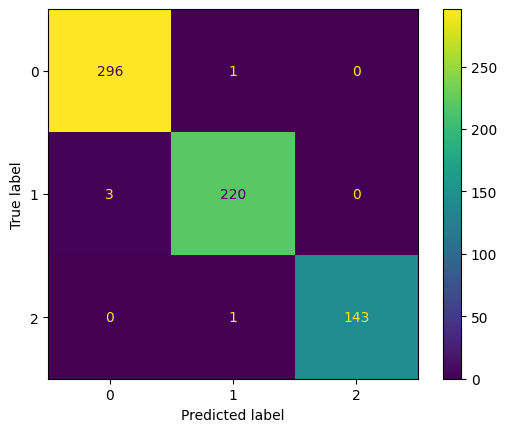

In [65]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds_SVC.round())
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.pink)


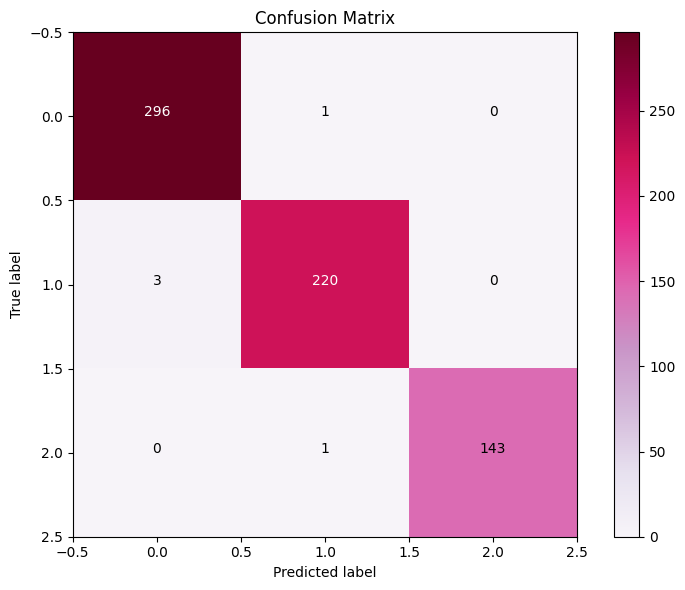

In [66]:
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding ticks and labels
# tick_marks = np.arange(len(cm))
# plt.xticks(tick_marks, ['Class 0', 'Class 1', 'Class 2','Class 3','Class 4','class 5','class 6'])
# plt.yticks(tick_marks, ['Class 0', 'Class 1', 'Class 2'])

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()